<a href="https://colab.research.google.com/github/bokutachi256/gisday2021/blob/main/1_%E6%9C%80%E5%88%9D%E3%81%AE%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3%5BGISDAY2021%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Pythonで作るマルチエージェントシミュレーション
* 東京都立大学 都市環境学部 地理環境学科 中山大地
* 2021年12月4日 東京都立大学 南大沢キャンパス（オンライン開催）
* このテキストのURL [https://github.com/bokutachi256/gisday2021](https://github.com/bokutachi256/gisday2021)
* Google ColaboratoryのURL [https://colab.research.google.com/](https://colab.research.google.com/)
* MESAのURL [https://mesa.readthedocs.io/](https://mesa.readthedocs.io/)

# はじめに

マルチエージェントシミュレーションは，振る舞いのルールがつけられた多数のエージェントが互いに影響し合っていく様子をシミュレートするもので，複雑なシステムの動向を解明するために用いられます．

本資料では，Pythonでマルチエージェントシミュレーションを実現するライブラリであるMesaを用いて，シンプルな避難シミュレーションを行います．

# この章でやること

この章では以下の内容を紹介します．

1. Mesaを用いたマルチエージェントシミュレーションの仕組み
1. Mesaのインストールと必要ライブラリのインポート
1. シンプルなモデルの構造
1. データコレクターからのデータ取り出し
1. アニメーションの作成

# Mesaを用いたマルチエージェントシミュレーションの仕組み

一般的なマルチエージェントシミュレーション（以下"MAS"と表記）は，シミュレーションの舞台となる空間（Mesaでは「スペース(Space)」と呼びます）と空間上で変化する「エージェント（Agent）」から構成されています．エージェントはスペース上に配置され，定められたルールに従って行動します．

Mesaのスペースは様々な種類があります．例えばグリッド座標系，連続直交座標系，六角格子網，グラフ（ネットワーク）などです．
スペースはオブジェクトとして作成され，コンストラクタを使って属性を定義します．

エージェントもオブジェクトになります．
こちらもスペースと同様にコンストラクタを使って属性を定義します．
また，メソッドとして行動のルールを記述します．

スケジューラーに登録されたエージェントは計算ステップごとにルールに従った行動をします．
また，エージェントならびにスペースのプロパティなどをデータコレクターに登録することにより，
計算ステップごとのエージェントの座標，プロパティの値，スペースの状態などを記録することができます．

計算終了後にデータコレクターから計算ステップごとの状態を取得することにより，アニメーションやグラフを作ることができます．
これがシミュレーション結果の可視化になります．


# Mesaのインストール

Google Colaboratoryには標準ではMesaが導入されていないため，
マジックコマンドを使ってMesaをインストールします．

In [ ]:
%pip install mesa

# 必要ライブラリのインポート

Mesaのインストールが終わったら必要ライブラリをインストールします．


```python
%matplotlib notebook
```
まずは図をインタラクティブに表示するためのおまじないです．

```python
import numpy as np
from tqdm import tqdm
```
配列計算を行うためのnumpyとループのプログレスバーを表示するためのtqdmをインポートします．

```python
import matplotlib.pyplot as plt
```
図化するためのライブラリをインポートします．

```python
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
```
アニメーション作成のためのライブラリです．
`from IPython.display import HTML`はGoogle Colaboratoryでアニメーション表示するために必要です．

```python
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
```
最後にMesa関係のライブラリです．
`from mesa import Agent, Model`はMesaのスペースとエージェントを読み込みます．
`from mesa.space import MultiGrid`はスペースとして同一座標に複数配置が可能なグリッド座標系を読み込みます．
`from mesa.time import RandomActivation`は計算ステップごとにランダムな順番でエージェントを動かすスケジューラーです．
`from mesa.datacollection import DataCollector`はデータコレクターの機能です．


それでは実際にライブラリを読み込んでみましょう．

In [ ]:
%matplotlib notebook

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# まずはシンプルなモデルから

まずはシンプルなモデルから始めましょう．

ここでは格子状のスペース上にスタート地点とゴール地点を設定します．
スタート地点に複数のエージェントを置き，エージェントはランダムに上下左右に動きます．
エージェントがゴールに着いたら避難したと見なし，エージェントは動きを止めます．
すべてのエージェントが避難完了したらシミュレーションを終了します．

## スペースを定義する


スペースを作成します．
スペースの仕様は以下のようにします．

* スペースはMultiGridを使う
* エージェントの初期位置はランダムに決定する
* ゴールは`goal_x`と`goal_y`とする
* エージェントは上下左右にランダムに動く
* データコレクターには以下の情報を格納する
 * model_reporter：ゴールした人数の累計，Stepごとのゴールした人数
 * agent_reporter：エージェントの座標とゴールしたかどうかの状態を保持


### スペースの生成


```python
class EvacModel(Model):
```
スペースを表すオブジェクトは`Model`になります．
ここではオブジェクト`Model`を継承した`EvacModel`を作成してスペースとします．


### スペースのコンストラクタ


オブジェクト`EvacModel`の中では，コンストラクタを使ってスペースの大きさ，
配置する避難者エージェントの数，スペースの種類などを定義します．

```python
  def __init__(self, N, width, height, goal_x, goal_y):
```
ここからコンストラクタです．
コンストラクタは`self`，`N`，`width`, `height`, `goal_x`, `goal_y`の引数があります．

```python
    self.num_agents = N
```
`N`は避難者エージェントの数を表します．
ここでは`self.num`としてスペースのプロパティ`num`を新たに作成し，値を`N`にします．

```python
    self.grid = MultiGrid(width, height, torus=False)
```
ここではスペースのタイプを設定します．
プロパティ`grid`を`MultiGrid`にします．
`MultiGrid`は同一座標に複数エージェントを配置できる格子状のスペースです．
`MultiGrid`には3個の引数があり，`width`はスペースの幅，`height`はスペースの高さです．`width`と`height`はコンストラクタの引数で与えられた値を使います．
最後の`torus=False`はスペースの上下左右の辺を繋げるかどうかの設定です．
`torus=True`にするとスペースの上下左右がつながり，ドラクエのようなスペースになります．
ここでは有限空間にするために`torus=False`にしています．

```python
    self.goal = (goal_x, goal_y)
```
プロパティ`goal`を作り，ゴールの座標を格納します．
ゴールの座標はコンストラクタの引数`goal_x`と`goal_y`で与えられており，両者をタプルにしてプロパティの値としています．

```python
    self.evac_comp = 0
```
計算ステップごとに何人避難完了したかを保持するプロパティ`evac_comp`を作成し，0で初期化します．

```python
    self.schedule = RandomActivation(self)
```
スケジューラーの設定です．
スケジューラーは計算ステップごとにエージェントを動かす仕組みです．
ここでは`RandomActivation`というスケジューラーを使用しています．
このスケジューラは計算ステップごとにランダムな順番でエージェントを動かします．
他にもエージェントを同時に動かす`SimultaneousActivation`もあります．

これでコンストラクタは終了です．



### 避難者エージェントをスペースに配置する



次はスペースに避難者エージェントを配置していきましょう．
ここではコンストラクタの引数`N`で指定された数の避難者エージェントをランダムな位置に配置します．

```python
    for i in range(self.num_agents):
```
`num_agents`回の`for`ループで避難者エージェントを配置します．

```python
      a = EvacAgent(i, self)
```
オブジェクト`a`として避難者エージェント`EvacAgent`を作成します．
`i`は避難者エージェントのユニークIDになります．

```python
      self.schedule.add(a)
```
オブジェクト`a`として生成された避難者エージェントをスケジューラーに登録します．
これによりこのエージェントは計算ステップごとに動くことができます．

```python
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
```
避難者エージェントの初期座標をランダムに決めます．x座標は0から`grid.width`の間，
y座標は0から`grid.height`の間になります．

```python
      self.grid.place_agent(a, (x, y))
```
`place_agent`用いて避難者エージェントをスペース上に配置します．
`place_agent`の引数は配置するエージェントのオブジェクト（ここでは`a`）と座標です．
座標はタプルで与えます．



### データコレクターの設定

次はデータコレクターです．
データコレクターはスペースやエージェントの状態を，計算ステップごとエージェントごとに記録します．
```python
      # データコレクターの設定
      self.datacollector = DataCollector(
```
プロパティ`datacollecter`を作成し，`DataCollector`を継承します．

データコレクターの引数には`model_reporters`と`agent_reporters`などがあります．
どちらの引数も値としてディクショナリを指定します．

```python
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
```
`model_reporters`にはスペースに関するデータを記録します．
ここでは`Goal`というキーと`evacuator`というキーで，
それぞれ`compute_goal`と`goal_pop`の値を格納しています．
ディクショナリの値として指定されている`compute_goal`と`goal_pop`は両方ともプログラム中で定義した関数で，
関数の戻り値が値としてデータコレクターに格納されます．
`compute_goal`は今までの計算ステップまでにゴールした人数の累計を求める関数で，
`goal_pop`はその計算ステップ中にゴールした人数をカウントする関数です．

```python
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})
```
`agent_reporters`はエージェントに関するデータを記録します．
キー`Pos`と`Goal`はそれぞれすべての避難エージェントの座標と避難エージェントがゴールしたかどうかを表す状態を示しています．
ディクショナリの値がクオーテーションマークで囲まれているので，`"pos"`と`"mygoal"`はそれぞれ避難エージェントのプロパティ`pos`と`mygoal`の値になります．

これらの関数の定義については後ほど解説します．



以上がデータコレクターの設定です．
データコレクターでデータを取得するには以下のようにします．
```python      
    self.datacollector.collect(self)
```


### 計算ステップごとのスペース挙動の定義

次に計算ステップごとにスケジューラに登録されたエージェントがどのような動きをするのか，`step`メソッドで定義します．

```python
  def step(self):
    model.evac_comp = 0
```

まず，プロパティ`evac_comp`を0で初期化します．

```python
    self.schedule.step()
```
次にスケジューラに登録されたエージェントの`step`メソッドを実行します．
```python
    self.datacollector.collect(self)
```
最後にデータコレクターでスペースとエージェントの状態を取得します．

### スペース定義のまとめ

以上でスペースの定義は完了です．
実際に動かしてみましょう

In [ ]:
class EvacModel(Model):
  def __init__(self, N, width, height, goal_x, goal_y):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントの初期位置をランダムに決定する
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      # エージェントを配置する
      self.grid.place_agent(a, (x, y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})
      
    self.datacollector.collect(self)
      
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)


## ゴール人数を求める関数

スペースの定義で用いていた関数を作成します．
ここではある計算ステップでゴールした人数をカウントする`goal_pop`，
今までにゴールした人数の累計を求める`compute_goal`を定義します．

```python
def goal_pop(model):
  return(model.evac_comp)
```
まずは`goal_pop`です．
戻り値はスペースのプロパティ`evac_comp`の値そのものです．
`evac_comp`の値は避難者エージェントの定義で
避難者エージェントがゴールした場合に1増やしています．
これについては避難者エージェントの定義の項で説明します．

```python
# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)
```
`compute_goal`はある計算ステップでゴールした人数の合計を求めます．
避難者エージェントは自分がゴールしたかどうかを表すプロパティ`mygoal`を持っています．
ゴールしたときに`mygoal`は1，ゴールしていないときには0になります．
これは避難者エージェントの中で定義しています．
`model.schedule.agents`はスケジューラーに登録されたエージェントのリストで，
内包表記を使ってすべての避難者エージェントのプロパティ`mygoal`の合計`sum`を求めます．
これが累計避難者数になります．



実際に実行してみましょう．

In [ ]:
# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

## 避難者エージェントを定義する

シンプルな避難者エージェントを定義します．
避難者エージェントの仕様は以下です．

* 避難者エージェントは避難が完了したかどうかを表すプロパティ`mygoal`を持つ．
* 計算ステップごとに上下左右にランダムに移動する．
* ゴールに達した場合はプロパティ`mygoal`を1にし，
累計避難者数を表すスペースのプロパティ`model.evac_comp`に1を加える


### 避難者エージェントの生成


```python
class EvacAgent(Agent):
```

エージェントを表すオブジェクトは`Agent`になります．
ここではオブジェクト`Agent`を継承した`EvacAgent`を作成して避難者エージェントとします．

### 避難者エージェントのコンストラクタ



```python
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
```
避難者エージェントのコンストラクタでは，自分がゴールしたかどうかの状態を保持するプロパティ`mygoal`を加えます．



### 避難者エージェントの移動メソッドの定義

避難者エージェントが移動する場合のルール（`move`メソッド）を記述します．

```python
  def move(self):
```
メソッド`move`を開始します．
引数は自分自身の避難者エージェント（インスタンス）を表す`self`です．
```python
    possible_steps = self.model.grid.get_neighborhood(
      pos=self.pos,
      moore = False,
      include_center = False)
```
まず，`model.grid.get_neighborhood`メソッドを使って自分の周囲のセルを取得します．
ここでは`model.grid.get_neighborhood`の引数として`pos=self.pos`，`moore=False`，`include_center=False`を与えています．

第一引数の`pos`は検索する中心セルの座標です．ここでは`self.pos`を使って避難エージェントの現在位置を与えています．
`self.pos`はAgentオブジェクトに組み込まれているプロパティで，Agentオブジェクトの現在座標を示します．
`moore`は周囲セルの検索方法で，
`False`の場合は上下左右の4セル，
`True`の場合は斜め方向も含む8セルになります．
ここでは上下左右のみ検索するので`False`にしています．
`include_center`は中心セルを戻り値に含めるかどうかです．
ここでは中心セルは含めないため`False`にしています．

`model.grid.get_neighborhood`メソッドの戻り値は周囲のセルの座標（x, y座標のタプル）のリストになります．
戻り値を変数`possible_steps`に代入します．

```python
    new_position = self.random.choice(possible_steps)
```
取得した周囲セルの座標リストから`random.choice`を使ってランダムに一つ選びます．
これを変数`new_position`に代入します．


```python
    self.model.grid.move_agent(self, new_position)
```
`model.grid.move_agent`メソッドを使って避難者エージェントを移動します．
`model.grid.move_agent`メソッドの引数は移動する避難者エージェントのインスタンス（ここでは自分自身であるために`self`とする）と移動先の座標です．移動先の座標は`new_position`にします．

これで避難者エージェントは上下左右のいずれかにランダムに移動します．

以上で`move`メソッドは終了です．



  ### ゴールに到達したか判定する関数



避難者エージェントがゴールに到達したかどうかを判断するメソッド`if_goal`を定義します．
避難者エージェントとの座標とゴールの座標が一致すればゴールしたことになります．

```python
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
```
`if`を使って避難者エージェントの現在位置`self.pos`とスペースで定義したゴールの座標を示すプロパティ`model.goal`が等しいか判断します．

座標が等しい場合はゴールしたと見なし，
避難者エージェントがゴールしたかどうかを表すプロパティ`mygoal`に1を加え（0に初期化されているので結果的に1になる），
さらにその計算ステップで何人ゴールしたかを示すスペースのプロパティ`model.evac_comp`にも1を加えます．



### 計算ステップごとの実行内容の定義

スケジューラーに登録されたエージェントは，計算ステップごとに`step`メソッドで定義された順番で行動します．
このプログラムでは避難者エージェントは上下左右にランダムに動き，その後でゴールしたかどうかを判断します．
これは以下のように書くことができます．

```python
  def step(self):
      self.move()
      self.if_goal()
```

`self.move()`で`move`メソッドを実行して上下左右にランダムに動き，
`self.if_goal()`でゴールをしたかどうか判断します．

しかしこのままではゴールしたエージェントも次の計算ステップでゴール地点から動いてしまいます．
このため，自分がゴールしたときには動かないようにします．

```python
  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()
```

プロパティ`mygoal`は自分がゴールしたかどうかの状態を保持するプロパティで，
値が0の時はまだゴールしていない状態で，1の時はゴールしている状態です．
`if`を使ってゴールしていない状態の時のみ移動し，その後にゴールしたかどうかの判定をします．

以上で避難者エージェントの定義はおわりです．

### 避難者エージェントの定義のまとめ

実際にプログラムを実行してみましょう

In [ ]:
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0

  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      pos=self.pos,
      moore = False,
      include_center = False)
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)

  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()


## シミュレーションを実行する

以上でスペースと避難者エージェントの定義，各種関数の定義が終わりました．
実際にシミュレーションを実行してみましょう．

実行の手順は以下になります．

1. スペースのインスタンスを作成する
1. 計算ステップの数だけスペースの`step`メソッドを実行する

### スペースのインスタンスを作成する

スペースのコンストラクタを呼び出してインスタンスを作成します．


コンストラクタの引数は以下となっています．
```python
def __init__(self, N, width, height, goal_x, goal_y):
```
`N`は避難者エージェントの数，
`width`はスペースの幅，
`height`はスペースの高さ，
`goal_x`はゴールのx座標，
`goal_y`はゴールのy座標です．

実際にはゴールの座標は変数として与えた方がよいので，
以下のような形になります．

```python
goal_x = 0
goal_y = 0
model = EvacModel(10, 5, 5, goal_x, goal_y)
```
5×5グリッドの大きさで10個の避難者エージェント，
ゴールの座標は(0, 0)というスペースが作成されました．
作成されたスペースのインスタンス名は`model`になります．


### スケジューラの設計

次にスケジューラを実行して避難者エージェントを動かします．
ループを使って実行するのが一般的です．
10ステップ実行するには以下のようにします．

```python
for i in range(10):
  model.step()
```

すべての避難者エージェントがゴールするまで実行するにはどのようにすれば良いでしょうか．
避難者エージェントは自分がゴールしたかを示すプロパティ`mygoal`を持っていますので，
すべての避難者エージェントの`mygoal`が1になったらループを終了するという方法が考えられます．
これは以下のように書くことができます．

```python
while min([agent.mygoal for agent in model.schedule.agents]) < 1:
  model.step()
```
`model.schedule.agents`はスケジューラーに登録されているすべてのエージェントのリストです．
内包表記を用いてリスト内のエージェントからプロパティ`mygoal`を取り出して新たなリストを作ります．
このリストの値は1か0となり，少なくとも一つの値が0である間はまだゴールしていないエージェントが存在することになります．
少なくとも1つが0かどうかは`min`を使ってリスト内の最小値を求めることで判別できます．
これを`while`ループの条件として，すべてのエージェントがゴールするまでスケジューラーを実行します．


### スケジューラーを実行する

それでは実際にスケジューラを実行しましょう

In [ ]:
goal_x = 0
goal_y = 0
model = EvacModel(10, 5, 5, goal_x, goal_y)
while min([agent.mygoal for agent in model.schedule.agents]) < 1:
  model.step()

# 計算結果を検討する


計算が終了したら計算結果を取り出して内容を検討します．
データコレクターにはすべての計算ステップごとのスペースの状態（累計避難完了者数とステップごとの避難完了者数）と
すべてのエージェントの状態（避難者エージェントの位置と避難者エージェントが避難完了したかどうか）が格納されています．

まずはデータコレクターからデータを取り出してみましょう．


## データコレクターからのデータ取り出し

### スペースに関するデータコレクターへのアクセス方法

スペースに関するデータコレクターは
```model.datacollector.get_model_vars_dataframe()```
でアクセスできます．
実際にスペースのデータコレクターを表示してみましょう．


In [ ]:
model.datacollector.get_model_vars_dataframe()

,Goal,evacuator
0,0,0
1,1,1
2,1,0
3,1,0
4,1,0
...,...,...
215,9,0
216,9,0
217,9,0
218,9,0


データコレクターはpandasのpandas.DataFrame型式でデータを保持しています．
これは重要なポイントです．

一番左の列が計算ステップ，2列目`Goal`が累計避難完了者数，3列目`evacuator`がステップごとの避難完了者数です．
計算ステップはDataFrameのインデックスになっています．


### スペースの状態変化をグラフ化する

データフレームの内容をシンプルな折れ線グラフにしてみましょう．

<function matplotlib.pyplot.show>

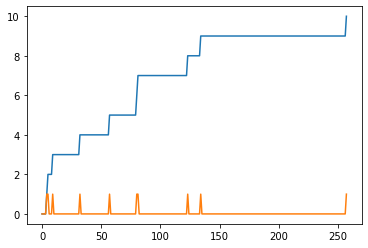

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show

matplotlibの`plot`を使ってシンプルにデータコレクターを折れ線グラフにしています．

### エージェントに関するデータコレクターへのアクセス方法

エージェントのデータコレクターには
`model.datacollector.get_agent_vars_dataframe()`
でアクセスします．

In [ ]:
model.datacollector.get_agent_vars_dataframe()

Pos  Goal
Step AgentID              
0    0        (1, 3)     0
     1        (2, 4)     0
     2        (0, 1)     0
     3        (2, 1)     0
     4        (1, 2)     0
...              ...   ...
257  5        (0, 0)     1
     6        (0, 0)     1
     7        (0, 0)     1
     8        (0, 0)     1
     9        (0, 0)     1

[2580 rows x 2 columns]

一番左の`Step`の列が計算ステップ，2列目の`AgentID`が避難者エージェントの番号，
`Pos`が避難者エージェントの座標，`Goal`が避難者エージェントがゴールしているかどうかです．

ここでは`Step`と`AgentID`の両方がDataFrameのインデックスになっており，
複数のインデックスがあるマルチインデックスになっています．

マルチインデックスの扱いは少々複雑で，
特定の計算ステップの情報を取り出したいときには`loc`メソッドを使って`Step`を指定します．

例えば計算ステップ0にアクセスしたい場合は以下のようにします．


In [ ]:
model.datacollector.get_agent_vars_dataframe().loc[0]

,Pos,Goal
AgentID,,
0,"(1, 3)",0
1,"(2, 4)",0
2,"(0, 1)",0
3,"(2, 1)",0
4,"(1, 2)",0
5,"(1, 2)",0
6,"(0, 3)",0
7,"(3, 4)",0
8,"(4, 4)",0


特定の避難者エージェントにアクセスしたいときには`xs`メソッドを使います．

例えばAgentID=0のみを取り出したいときは以下のようにします．

In [ ]:
model.datacollector.get_agent_vars_dataframe().xs(0, level='AgentID')

,Pos,Goal
Step,,
0,"(1, 3)",0
1,"(1, 2)",0
2,"(0, 2)",0
3,"(1, 2)",0
4,"(2, 2)",0
...,...,...
253,"(0, 0)",1
254,"(0, 0)",1
255,"(0, 0)",1


AgentID=0の位置のみを取り出すときには以下のようにします．

In [ ]:
model.datacollector.get_agent_vars_dataframe().xs(0, level='AgentID')['Pos']

Step
0      (1, 3)
1      (1, 2)
2      (0, 2)
3      (1, 2)
4      (2, 2)
        ...  
253    (0, 0)
254    (0, 0)
255    (0, 0)
256    (0, 0)
257    (0, 0)
Name: Pos, Length: 258, dtype: object

## 任意の計算ステップでの避難者エージェントの位置を図化する

計算ステップごとの避難エージェントの位置をプロットしてみましょう．
基本的な形は以下のようになります．

```python
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
ax.text(goal_x, goal_y, 'Goal', size = 10, ha = 'center')
ax.scatter(goal_x, goal_y, s = 1000, marker = "s")

ax.scatter(
  ある計算ステップにおけるすべての避難者エージェントのx座標の配列,
  ある計算ステップにおけるすべての避難者エージェントのy座標の配列,
  s=600, c="red", marker="*")
ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()
```



特に複雑な図ではないのですが，ある計算ステップにおけるすべての避難者エージェントの座標を取得するところがポイントになります．

例としてStep=0のすべての避難者エージェントの座標を取得します．

In [ ]:
model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']

AgentID
0    (1, 3)
1    (2, 4)
2    (0, 1)
3    (2, 1)
4    (1, 2)
5    (1, 2)
6    (0, 3)
7    (3, 4)
8    (4, 4)
9    (0, 2)
Name: Pos, dtype: object

取得した座標値はx座標とy座標が組（タプル）になったリストです．
これをx座標のリストとy座標のリストに分けます．

`for`ループを使えば以下のようにすることができます．

```python
x = []
y = []
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']
for i in range(len(agent_loc)):
  x.append(agent_loc[i][0])
  y.append(agent_loc[i][1])
```

しかしこれはあまりpython的ではなく，エレガントとは言えません．

Pythonらしく書くと以下のようになります．

```python
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']
x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
```
タプルのリストから内包表記を使ってx座標とy座標それぞれのリストを取り出します．


実際に実行してみます．

In [ ]:
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(1, level='Step')['Pos']
x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
print(x)
print(y)

[1, 2, 1, 2, 0, 1, 0, 3, 3, 1]
[2, 3, 1, 0, 2, 3, 2, 3, 4, 2]



これで各避難者エージェントの座標が取得できたので，散布図を作ってみましょう．
ここではStep=0の状態を表示します．

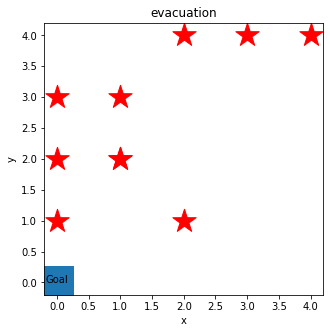

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
ax.text(goal_x, goal_y, 'Goal', size = 10, ha = 'center')
ax.scatter(goal_x, goal_y, s = 1000, marker = "s")

agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']
x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
ax.scatter(x, y, s=600, c="red", marker="*")
ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

## 避難者エージェントの動きをアニメーションにする

任意の計算ステップでの避難者エージェントの位置をプロットできたので，これを使ってアニメーションを作ってみます．

アニメーションは以下のような形で作成します．

```python
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size = 14, ha = 'center')
plt.scatter(goal_x, goal_y, s = 800, marker = "s")

# グラフを保持するリストの生成
ims=[]

for i in range(計算ステップ数): 
  im = ax.scatter(避難エージェントのx座標配列, 避難エージェントのy座標配列, s=1000, c="red", marker="*")
# グラフをリストに加える
  ims.append([im])

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 150)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim
```

基本的には一枚のプロットを作るのと同じですが，
作成したプロットは配列（リスト）に追加し，
すべての計算ステップにおけるプロットを追加し終わったら一括してアニメーションを作成します．

アニメーションを作成するには以下のようにします．
```python
anim = animation.ArtistAnimation(fig, ims, interval = 150)
```

引数`fig`は図のインスタンス，`ims`は図を格納したリストです．
`intaerval`はアニメのコマ間で，ms（ミリ秒）で指定します．

作成したアニメーションを表示するには以下を実行します．
```python
rc('animation', html='jshtml')
plt.close()
anim
```
`rc('animation', html='jshtml')`はGoogle Colaboratory上でアニメーションを表示するのに必要です．

アニメーションの生成には意外と時間がかかります．
メモリも使いますので，ステップ数が多いとアニメーションができないこともあるので注意してください．

それでは実際にアニメーションを作成してみましょう．
ここでは100ステップ目までのアニメーションを作成します．

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size = 14, ha = 'center')
plt.scatter(goal_x, goal_y, s = 800, marker = "s")

ims=[]

# 100ステップまでアニメーションを作成する
for i in range(100): 
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos']
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  im = ax.scatter(x, y, s=1000, c="red", marker="*")
# グラフをリストに加える
  ims.append([im])

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 150)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim


## なめらかなアニメーションを作る

作成したアニメーションはパラパラアニメすぎたので，
一つ前の計算ステップからの避難エージェントの移動量を内挿して補間をします．
これによりある程度アニメーションをなめらかにすることができます．

また，アニメーションのループに`tqdm`を使ってプログレスバーを表示させています．

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size = 14, ha = 'center')
plt.scatter(goal_x, goal_y, s = 800, marker = "s")

ims = []

# 計算ステップ間の補間数
step = 3

# 0 Step目のエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 100)): 
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos']
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  # 前の計算ステップの避難エージェント位置との差分を取り，補間を行う．
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  for u in range(step):
    #補間数分のループを使って避難エージェントの座標を内挿する
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c="red", marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

## スペース属性のアニメーション

おまけとしてスペースの状態（累計避難完了者数と計算ステップごとの避難完了者のグラフ）もアニメーションにしてみました．

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

ims=[]
for i in range(100): 
  goal = model.datacollector.get_model_vars_dataframe()[0:i]
  im = ax.plot(goal, color="red")

# グラフをリストに加える
  ims.append(im)

ax.set_title('evacuation')
ax.set_xlabel('Step')
ax.set_ylabel('Goal')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval=50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

# ここまでのまとめ

ここまでの内容をまとめました．


## スペースとエージェントを定義してモデルを実行する

In [ ]:
%pip install mesa
%matplotlib notebook

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

def goal_pop(model):
  return(model.evac_comp)

def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

class EvacModel(Model):

  def __init__(self, N, width, height, goal_x, goal_y):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントの初期位置をランダムに決定する
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      # エージェントを配置する
      self.grid.place_agent(a, (x, y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal"})
      
    self.datacollector.collect(self)
      
  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0

  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
      self.pos,
      moore = False,
      include_center = False)
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)

  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()

# モデルの実行
goal_x = 0
goal_y = 0
model = EvacModel(10, 5, 5, goal_x, goal_y)
while min([agent.mygoal for agent in model.schedule.agents]) < 1:
  model.step()

## 計算結果のアニメーション

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size = 14, ha = 'center')
plt.scatter(goal_x, goal_y, s = 800, marker = "s")

ims = []
step = 3

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos']
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 100)): 
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos']
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  for u in range(step):
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c="red", marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

## スペースの状態をグラフ化する

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show